In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using Distributions
using PyPlot
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/auxiliary/buffer.jl")
include("../functions/preprocessing.jl")

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


fft_expand (generic function with 1 method)

In [2]:
mutable struct AutoregressiveFilterbank <: ForneyLab.SoftFactor
    id::Symbol
    interfaces::Vector{Interface}
    i::Dict{Symbol,Interface}

    function AutoregressiveFilterbank(y, x, Œ∏, w; id=ForneyLab.generateId(AutoregressiveFilterbank))
        
        # ensure that the input arguments are random variables
        @ensureVariables(y, x, Œ∏, w) 
        
        # create new object
        self = new(id, Array{Interface}(undef, 4), Dict{Symbol,Interface}())
        
        # add the node to the current factor graph
        ForneyLab.addNode!(currentGraph(), self)
        
        # add argument variables to interfaces of node
        self.i[:y] = self.interfaces[1] = ForneyLab.associate!(Interface(self), y)
        self.i[:x] = self.interfaces[2] = ForneyLab.associate!(Interface(self), x)
        self.i[:Œ∏] = self.interfaces[3] = ForneyLab.associate!(Interface(self), Œ∏)
        self.i[:w] = self.interfaces[4] = ForneyLab.associate!(Interface(self), w)
        
        # return object
        return self
    end
end

In [3]:
# add shortcut for calling the filter bank
slug(::Type{AutoregressiveFilterbank}) = "ARFB"

slug (generic function with 1 method)

In [4]:
function ruleVariationalARFBOutNPPP(marg_y::Nothing, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_Œ∏::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})

    # calculate required means
    mŒ∏ = ForneyLab.unsafeMean(marg_Œ∏)
    mx = ForneyLab.unsafeMean(marg_x)
    mw = ForneyLab.unsafeMean(marg_w)
                        
    # calculate new parameters
    my = mŒ∏ .* mx
    wy = mw

    # create variational message
    return Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=wy*my, w=wy)

end

ruleVariationalARFBOutNPPP (generic function with 1 method)

In [5]:
function ruleVariationalARFBIn1PNPP(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::Nothing, 
                                    marg_Œ∏::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})
    
    # caluclate required means
    my = ForneyLab.unsafeMean(marg_y)
    mŒ∏ = ForneyLab.unsafeMean(marg_Œ∏)
    mw = ForneyLab.unsafeMean(marg_w)

    # calculate required variances
    vŒ∏ = ForneyLab.unsafeCov(marg_Œ∏)

    # calculate new parameters
    wx = (vŒ∏' + mŒ∏*mŒ∏') .* mw
    mx = inv(wx) * Diagonal(mŒ∏) * mw * my

    # create variational message
    return Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=wx*mx, w=wx)

end

ruleVariationalARFBIn1PNPP (generic function with 1 method)

In [6]:
function ruleVariationalARFBIn2PPNP(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_Œ∏::Nothing, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})

    # calculate required means
    my = ForneyLab.unsafeMean(marg_y)
    mx = ForneyLab.unsafeMean(marg_x)
    mw = ForneyLab.unsafeMean(marg_w)

    # calculate required variances
    vx = ForneyLab.unsafeCov(marg_x)

    # calculate new parameters
    wŒ∏ = (vx' + mx*mx') .* mw
    mŒ∏ = inv(wŒ∏) * Diagonal(mx) * mw * my

    # create variational message
    Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=wŒ∏*mŒ∏, w=wŒ∏)

end

ruleVariationalARFBIn2PPNP (generic function with 1 method)

In [7]:
function ruleVariationalARFBIn3PPPN(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_Œ∏::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::Nothing)

    # calculate required means
    my = ForneyLab.unsafeMean(marg_y)
    mx = ForneyLab.unsafeMean(marg_x)
    mŒ∏ = ForneyLab.unsafeMean(marg_Œ∏)

    # calculate required variances
    vy = ForneyLab.unsafeCov(marg_y)
    vx = ForneyLab.unsafeCov(marg_x)
    vŒ∏ = ForneyLab.unsafeCov(marg_Œ∏)

    # calculate new parameters
    v = vy + my*my' - (mŒ∏ .* mx)*my' - my*(mx .* mŒ∏)' + Diagonal(mŒ∏)*vx*Diagonal(mŒ∏) + Diagonal(mx)*vŒ∏*Diagonal(mx)  + (mŒ∏ .* mx)*(mŒ∏ .* mx)' + vŒ∏.*vx
    nu = size(v,1) + 2 

    # create variational message
    Message(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=inv(v), nu=nu)

end

ruleVariationalARFBIn3PPPN (generic function with 1 method)

In [8]:
@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (Nothing, ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VariationalARFBOutNPPP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, Nothing, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VariationalARFBIn1PNPP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, ProbabilityDistribution, Nothing, ProbabilityDistribution),
                      :name          => VariationalARFBIn2PPNP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{ForneyLab.Wishart},
                      :inbound_types => (ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution, Nothing),
                      :name          => VariationalARFBIn3PPPN)


In [9]:
function generateARFB(nr_Œ≥, bufsize)
    
    model = quote
        
        fg = FactorGraph()
        
        @RV [id=:smin] smin ~ GaussianMeanVariance(placeholder(:Œº_smin, dims=(2*$nr_Œ≥,)), placeholder(:Œ£_smin, dims=(2*$nr_Œ≥,2*$nr_Œ≥)))
        @RV [id=:Œ∏] Œ∏ ~ GaussianMeanVariance(placeholder(:Œº_Œ∏, dims=(2*$nr_Œ≥,)), placeholder(:Œ£_Œ∏, dims=(2*$nr_Œ≥,2*$nr_Œ≥)))
        @RV [id=:w] w ~ ForneyLab.Wishart(placeholder(:v_w, dims=(2*$nr_Œ≥,2*$nr_Œ≥)), placeholder(:nu_w))
        @RV [id=:s] s ~ AutoregressiveFilterbank(smin, Œ∏, w)
        @RV [id=:x] x = placeholder(:c, dims=($bufsize,2*$nr_Œ≥)) * s
        @RV [id=:y] y ~ GaussianMeanVariance(x, placeholder(:Œ£_x, dims=($bufsize,$bufsize)))
        placeholder(y, :y, dims=($bufsize,))
        
        q = PosteriorFactorization(smin, s, Œ∏, w, ids=[:smin, :s, :Œ∏, :w])

    end
    
end

generateARFB (generic function with 1 method)

In [10]:
# load speech data
xi, fs = wavread("../data/airco.wav", format="native")
fs = Int(fs)
xi = convert(Array{Float64,1}, xi[1*fs:4*fs])

# pre-process signals
yi = preprocess(xi, fs) 

N = length(yi)
t = collect(1:N)/2000
fs = 2000

audioplayers(yi, fs=2000);

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEA0AcAAEAfAAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQCsZgw+p76QPi+woD5FjbU+F4u1PmTHzD58EOo+RkkDP68iDT9uSgM/fvvdPlgozT5cGbw+RErRPjlKzz6kJMc+/Q6YPlbLjz4wAJI+jjquPnVEmD4Qyns+m7mBPu+gBj7PAi8+AvwiPq5FVbyWY0G+Eud+vkwLKL4wNr85DNvOPfZu+7sP6c69oz08vs+tA74t2Dy9eZkNviFKLL5ECIC+q0LNvqfC5b5Zjui+GfqSvv1emb6PMni+uFKbvmhQt74yJL6+ikftvhtDBr8ujP6+lfYJv2A/9b5XacS+GX5yvmTGZL6xk5e+wR6PvuE2b76Ga1q+SvO7vT1nVr11UFy8VkvKvUDbjL5KjKS+T/FbvjGhaL2sHnA9oNyhPOYblL1og6K9tQaLPXjsbT5OOmQ+F48+PhKelD3HVfY8o/CAPtUi6T6Dvwc/OIbcPoggnT5RuK8+w6H9Ph88Ij989Ck/23IKPzeTFz+YjSE/bmE1PwnEKj+sowg/Uuz1PsDU6T5DwOg+nP3pPr6Cvj5Cgoo+hlqKPi4JvT6BIas+3g4pPgaRn7xMnB+9BJymPIs87z2VFO88IIYDvvreq75+uta+bsyzvt3aUL4bgF2+tKCkvgnXyL7krOC+QlDsvh+F3b5x2dy+I3HVvpRRvb6sbre+smyqvpQjtr7owIG+i5h4vrJLg77gIl++vn9uvuAAg77KJVC+66iFvsqAhb4x/nq+lhJ7vjaVQb6xLQ2+7wOJvovf/L4zAhi/5d4Jv7PZ177oUIe+F1FVvmVAYL752bm+20e/vm6VuL6UrKq+2WhpvmVBCr6o8yK+OJTQvUN8iL3q7Ym9ercsObeKLj7VaaI+df7CPvLdxT6+QZs+XtOZPlMHxj7qcAM/EgUlP2GFKT8w7RA/rET/PqVrAD/1UiE/E9VCPxHIKj+7BAg/82e7PkFFoz6oZ64+yx/4Pg2PMz+hCD8/Du4wPxBoCj+4fQA/JpHePr1n7D7AbNY+HsKbPiyQbT6c8UE+O0s2PlYJBT4rWd48ToyNvQ4TXL4sFm++ZuFvvlNlhr6S67K+P4wBv9dSIr8xJB6/0SEKv3/U8r4obQe/tAEev1yMOb+3/TG/tyYav1L7G79Snye/x1QSv8OkB7+CguK+OvXevooz275V7dW++ca5vmGdkL7H1pS+glSIvrAVYL5yEzy+aPk2vskKJL7iCzK+3U26vRPsRL5oW9K9tG6VPR5TpT2+gvs8RejvvZV7QL0/p2C9GlCNuBxCTD6Wj2o+2+eJPT/sbLy42TU95K9hPpgkvz7Ak+o+7bLjPiDhqz6PC7o+hYDKPqPM2z5Ba9U+yNrNPvZPtj40C5c+uD1+PuIVrj5427g+/orWPtdH0T7xxbo++fWPPjZRRT4kjKs9JbY8PuGsfz6/dLE+iIqnPl1qSj5atfE9UDWfPejhaz4RXq4+F/y7PnfrqD7Q+JY964jPPO/Ppj2WOrs9pW+CPYvAtrw+PTO9kaN7vWUy2rvDab084jUSvQY1Eb771lG+XdBdvse2KL7gc02+Q8LmvhYNA7+QMBW/FDANv882877uVQq/srosvx/SS78Erjy/GBEtv1ZFFr/8I/m+TB4Sv4xBD79a9f++CrGUvuUKQr5JOE2+eVQovuOR+b2kCP67IT2iPcQ4xj3j4909DnskPq+xkT4wMqA+VN99PrbBIj4cPaU9kK59PXLCmT5NVb4+A1a7PipelD6yua89crFKPXwPlD3RfYg+Ce6kPrTzfT67618+kA+KPj38nT5Sr7s+e+LWPtgGyz53xas+76onPlc0lD64V7s+In7cPkgVzj4yWKw+z4V+Pnk/eT4WCpE+LL+FPqlsbT75nyI+k9b1Pa8uID4Q0/49D/MJPjCWEj7GOc09Eyi1Pb4mRz10XnI97HrRPLWLq712iwm+ecnIvUq8kr1v+Cy9b5WQu9T99b1uI06+HMJzvovfWb5lrdm97A89vrIIq752dty+W4Lmvj9qB78jugK/u54Bv19iA7+iXQO/O/UUv/zrKL+K8FO/9IxtvyIzXL/lkU2/HD8vv7y6Hr8zxxa/GikUv2GHAL9POdG+XBKgvsUmOL4dWvC9fc7JvXROxj1h8m8+dFDDPly4AD+IOOA+F5uzPi1MtT4ROsw+JcLyPgOiHz94uyM/GfgSPxwk8j7hW+U+awwTP3hyHz+QHhI/22z/PlNZ2z420fY+smEOPygnCD+UMPg+Kh+/PglKtz40bK4+uJXAPi1owj7IDqY+kICOPsJyoj7tXLI+N3CsPvXhaD7y/UI+B+VlPmvghT6AyKc+bbuHPnM3Kj6FV7y6cNrIvb8bjL2AwCG+phRlvh26ib51taa+B3NqvjZzVb7uFo6+cxjevvsaFL/+Awy/tXP/vuoBB78QZxq/T2Uuv6hiH7/h3AC/a9Sovsu/iL6Z18i+AtUNv2YJHL8C1AO/RKO/vob3pr71DZW+FI2cvvO6o76hNUi+cJo3vpUyQ778jBq+ryHbvQ7bjb1Osk69w8+qva5wTb6J5k2+FqBDvVhb9j0IUFM+eo34PWXp2j0wRdI8PQYIPgOVHj68EIA90kVLPdSodj3A9zM+suOOPltQoT6oNpc+gT+mPs62xj7RP/k+rPcZP/6mIj8ECwQ/64HmPpdH7j58tc4+MK4KP+TX8z4jw+A+saUEP1OMDz+u0Ac/TNYIP9r0Gz9FXgc/jMXxPm9jzT4kZZs+FJCUPscHtT4d3a0+slNVPjSIwz0zyTO89VQFvrfLBL4qo4K+rnB0vq4ok74Vx6K+YZ/MvmIbFL/4USe/+BUVv8PhAb9dAgi/76Ukv8W7Vb/932q/ilhjv+32Q7+G1g+/PhMGv7To/L7jPfC+p0rzvv5b4b4EtcW+Kbfmvgips75cvYq+xKQHvi/Ohb053tO998hNvnaxbL72Qxq+TkGHPd/9ZD2J+x+937vIvZFza72C9F09IJtRPjzxbT4hXD8+GkAlPiUEaT4V2Yo+4+LNPoyl9z7betQ+asvHPqNKzD7MFtc+ePubPqgbXD55QMs9T+9XPtQFuz57tP4+5MThPmnYmD6BXSA+pwFCPlCsuD6vheg+pdvpPgZg9z5tnOQ+1CwUP9i7Fj/IEBg/0In8PuWLuj4OW5w+UGe3PqxC9T4xtA0/PqX6Pshypz4boz8+uT4GPmCwJT7J0So+zHbpPa1U+bydbaC98b4Qvrx62LziwwA9SLpsPI2P7r09Xny+3ty6vnvNBr89JBi/+q0ev2XjF797XiK/zWwUv3HdC78UFRe/GJISv6QXDL9J8h2/eagmv4zaKL/j+y2/Z+pOv5aSTL8fpjK/R3stv8qqGb9rCPu+qY/vvu9Dxr5cV8u+/R7ivuJvrb49G56+E9WOvjexVr6h5VG+D03OvbuhuDwp4e49VzpuPi48gT5nF5Q+n5yVPjp8hD7dd6Y+Ala/PnT9rD7gIro+VS2xPvoDmT721s8+jgfIPgXD0T70Hrs+ubiaPki7NT46eg4+1SNHPeOkPj4XwZM+oWbEPlMMqz6hzmg+64OPPnTJuT4w3cE+p9GMPo+9Fz7qHm88unRmPnvJ4D4YWBU/g6MJP5Kzrz7VjAY+mhqHPX8z+j1Yv5s+U16iPrAzVD5Gtim9TB80vpdW7r2WfG89XDm9PU0cJL31fBK+P+Jivn3pnb7o7a2+RT/Cvs2M8b7PQAy/tBr2vuY+777ZjM++CRvKvmbB5b7RTOK+zl/3vlBWAb+n6/G+ZjX0voqMx76IPIq+gxBZvnLeKL5O8Ui+zOVDvvpFHTyyk4E+SHvTPvSpoz7SnBo+L+HzPHd+uTzrcCU+aBuhPp1Psj45tqw+87w/Pr1t8z29O4A+bZe+Pt6c2j6x0

In [11]:
f = collect(fs/60:fs/60:fs/2)
bufsize = 4*length(f)

# create fg
eval(generateARFB(length(f), bufsize))
ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3407430974488816058 -->
 3407430974488816058 
 
 placeholder_nu_w 
 
<!-- 1131663310226791017 -->
 1131663310226791017 
 
 ùí© 
 gaussianmeanvariance_3 
 
<!-- 14007158175761770032 -->
 14007158175761770032 
 
 √ó 
 multiplication_1 
 
<!-- 1131663310226791017--14007158175761770032 -->
 1131663310226791017--14007158175761770032 
 
 x 
 1 out 
 2 m 
 
<!-- 5805894913559269803 -->
 5805894913559269803 
 
 placeholder_Œ£_x 
 
<!-- 1131663310226791017--5805894913559269803 -->
 1131663310226791017--5805894913559269803 
 
 Œ£_x 
 1 out 
 3 v 
 
<!-- 1300090844875609869 -->
 1300090844875609869 
 
 placeholder_y 
 
<!-- 1300090844875609869--1131663310226791017 -->
 1300090844875609869--1131663310226791017 
 
 y 
 1 out 
 1 out 
 
<!-- 11597527895633469797 -->
 11597527895633469797 
 
 AutoregressiveFilterbank 
 autoregressivefilterbank_1 
 
<!-- 1352614032369256876 -->
 1352614032369256876 
 
 ùí© 
 gaussianmeanvariance_1 
 
<!-- 11597527895633469797--1352614032369256876 -->
 11597527895633469797--1352614032369256876 
 
 smin 
 1 out 
 2 x 
 
<!-- 16219849354866514237 -->
 16219849354866514237 
 
 W 
 wishart_1 
 
<!-- 11597527895633469797--16219849354866514237 -->
 11597527895633469797--16219849354866514237 
 
 w 
 1 out 
 4 w 
 
<!-- 11475426081976402036 -->
 11475426081976402036 
 
 ùí© 
 gaussianmeanvariance_2 
 
<!-- 11597527895633469797--11475426081976402036 -->
 11597527895633469797--11475426081976402036 
 
 Œ∏ 
 1 out 
 3 Œ∏ 
 
<!-- 14007158175761770032--11597527895633469797 -->
 14007158175761770032--11597527895633469797 
 
 s 
 1 y 
 2 in1 
 
<!-- 13253780441540418356 -->
 13253780441540418356 
 
 placeholder_c 
 
<!-- 14007158175761770032--13253780441540418356 -->
 14007158175761770032--13253780441540418356 
 
 c 
 1 out 
 3 a 
 
<!-- 3236139213282110156 -->
 3236139213282110156 
 
 placeholder_Œº_Œ∏ 
 
<!-- 12487559452250828856 -->
 12487559452250828856 
 
 placeholder_Œ£_smin 
 
<!-- 6836461845798333671 -->
 6836461845798333671 
 
 placeholder_v_w 
 
<!-- 1309582993388049087 -->
 1309582993388049087 
 
 placeholder_Œº_smin 
 
<!-- 1352614032369256876--12487559452250828856 -->
 1352614032369256876--12487559452250828856 
 
 Œ£_smin 
 1 out 
 3 v 
 
<!-- 1352614032369256876--1309582993388049087 -->
 1352614032369256876--1309582993388049087 
 
 Œº_smin 
 1 out 
 2 m 
 
<!-- 16219849354866514237--3407430974488816058 -->
 16219849354866514237--3407430974488816058 
 
 nu_w 
 1 out 
 3 nu 
 
<!-- 16219849354866514237--6836461845798333671 -->
 16219849354866514237--6836461845798333671 
 
 v_w 
 1 out 
 2 v 
 
<!-- 10188863108854744930 -->
 10188863108854744930 
 
 placeholder_Œ£_Œ∏ 
 
<!-- 11475426081976402036--3236139213282110156 -->
 11475426081976402036--3236139213282110156 
 
 Œº_Œ∏ 
 1 out 
 2 m 
 
<!-- 11475426081976402036--10188863108854744930 -->
 11475426081976402036--10188863108854744930 
 
 Œ£_Œ∏ 
 1 out 
 3 v

In [12]:
# generate algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))
println(source_code)

begin

function stepw!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBWishartOut(nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:v_w]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:nu_w]))
messages[2] = ruleVariationalARFBIn3PPPN(marginals[:s], marginals[:smin], marginals[:Œ∏], nothing)

marginals[:w] = messages[1].dist * messages[2].dist

return marginals

end

function steps!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVariationalARFBOutNPPP(nothing, marginals[:smin], marginals[:Œ∏], marginals[:w])
messages[2] = ruleSPMultiplicationOutNGP(nothing, messages[1], Message(MatrixVariate, PointMass, m=data[:c]))
messages[3] = ruleVBGaussianMeanVarianceM(ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:y]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Œ£_x]))
messages[4] = ruleSPMultiplicat

In [13]:
yifft = FFTovertime(yi, bufsize, bufsize-1, rectangularwindow; pad=0)
yifftr = real.(yifft)
œÅ = [cor(yifftr[2:end,k], yifftr[1:end-1,k]) for k = 2:length(f)+1]
œÅw = [1/var(yifftr[2:end,k]-œÅ[k-1]*yifftr[1:end-1,k]) for k=2:length(f)+1]
œÅ = repeat(œÅ, inner=2)
œÅw = repeat(œÅw, inner=2)

60-element Array{Float64,1}:
  1.959981733993374 
  1.959981733993374 
  2.32444632661017  
  2.32444632661017  
  1.1658728942153949
  1.1658728942153949
  0.507129001250251 
  0.507129001250251 
  3.174696579410464 
  3.174696579410464 
  4.303708400536887 
  4.303708400536887 
  7.696062895031451 
  ‚ãÆ                 
  4.810690590578337 
  4.810690590578337 
  4.514183094612703 
  4.514183094612703 
  8.213228928106426 
  8.213228928106426 
  8.194915195847125 
  8.194915195847125 
  6.338181966395934 
  6.338181966395934 
 12.54347519698754  
 12.54347519698754  

In [14]:
Œº_Œ∏_mem = Array{Float64,2}(undef, N, 2*length(f))
Œ£_Œ∏_mem = Array{Float64,2}(undef, N, 2*length(f))
Œº_s_mem = Array{Float64,2}(undef, N, 2*length(f))
Œº_x_mem = Array{Float64,1}(undef, N)
Œ£_x_mem = Array{Float64,1}(undef, N)

# priors
Œº_smin = zeros(2*length(f))
Œ£_smin = 0.01*Ic(2*length(f))
Œº_Œ∏ = œÅ #ones(2*length(f))
Œ£_Œ∏ = 1e-2*Ic(2*length(f))
v_w = 10*diagm(œÅw)/(2*length(f) + 2)
nu_w = 2*length(f) + 2
Œ£_x = 1e-4*Ic(bufsize)

p = Progress(N-bufsize)
    marginals = Dict()

for n = bufsize:N
    
    next!(p)
    
    # fill marginals dictionary
    marginals[:smin] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=Œº_smin, v=Œ£_smin)
    marginals[:Œ∏] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=Œº_Œ∏, v=Œ£_Œ∏)
    marginals[:w] = ProbabilityDistribution(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=v_w, nu=nu_w)
    
    # fill data dictionary
    data = Dict()
    data[:Œº_smin] = Œº_smin
    data[:Œ£_smin] = Œ£_smin
    data[:Œº_Œ∏] = Œº_Œ∏
    data[:Œ£_Œ∏] = Œ£_Œ∏
    data[:v_w] = v_w
    data[:nu_w] = nu_w
    data[:c] = reshape( [cos.(2*pi*f*t[n-bufsize+1:n]') sin.(2*pi*f*t[n-bufsize+1:n]')]', bufsize, 2*length(f))#cos.(2*pi*f*t[n-bufsize+1:n]')'
    data[:Œ£_x] = Œ£_x*Ic(bufsize)
    data[:y] = yi[n-bufsize+1:n]   
    
    # make prediction
    messages = Array{Message}(undef, 4)
    Base.invokelatest(steps!, data, marginals, messages)
    Œº_x_mem[n] = ForneyLab.unsafeMean(messages[2].dist)[end]
    Œ£_x_mem[n] = ForneyLab.unsafeCov(messages[2].dist)[end,end]
    
    # perform updates
    for _ in 1:5
        Base.invokelatest(steps!, data, marginals)
        Base.invokelatest(stepŒ∏!, data, marginals)
        Base.invokelatest(stepw!, data, marginals)
        Base.invokelatest(stepsmin!, data, marginals)
    end
    
    # update parameters
    Œº_smin = ForneyLab.unsafeMean(marginals[:s])
    Œ£_smin = ForneyLab.unsafeCov(marginals[:s])
    Œº_Œ∏ = ForneyLab.unsafeMean(marginals[:Œ∏])
    Œ£_Œ∏ = ForneyLab.unsafeCov(marginals[:Œ∏])
    v_w = marginals[:w].params[:v]
    nu_w = marginals[:w].params[:nu]

    # save parameters
    Œº_Œ∏_mem[n,:] = Œº_Œ∏
    Œ£_Œ∏_mem[n,:] = diag(Œ£_Œ∏)
    Œº_s_mem[n,:] = Œº_smin
    
end

Progress: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:57:01m24mm9mm9mm


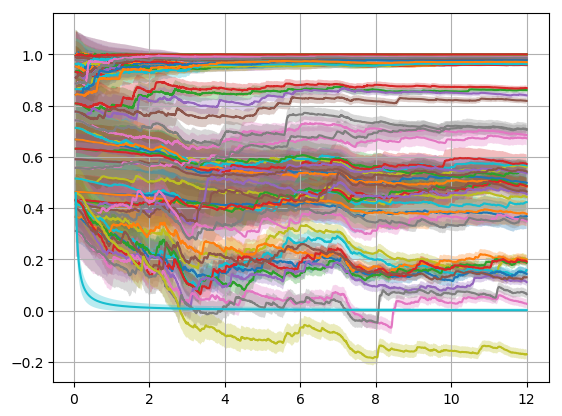

In [15]:
for k = 1:size(Œº_Œ∏_mem,2)
    plt.plot(t[bufsize:end], Œº_Œ∏_mem[bufsize:end,k])
    plt.fill_between(t[bufsize:end], Œº_Œ∏_mem[bufsize:end,k].+sqrt.(Œ£_Œ∏_mem[bufsize:end,k]), Œº_Œ∏_mem[bufsize:end,k].-sqrt.(Œ£_Œ∏_mem[bufsize:end,k]), alpha=0.3)
end
plt.grid()

<source src="data:audio/wav;base64,UklGRmR1AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YSh1AQAfhd2+cdncviNx1b6UUb2+rG63vrJsqr6UI7a+6MCBvouYeL6yS4O+4CJfvr5/br7gAIO+yiVQvuuohb7KgIW+Mf56vpYSe742lUG+sS0Nvu8Dib6L3/y+MwIYv+XeCb+z2de+6FCHvhdRVb5lQGC++dm5vttHv75ulbi+lKyqvtloab5lQQq+qPMivjiU0L1DfIi96u2JvXq3LDm3ii4+1WmiPnX+wj7y3cU+vkGbPl7TmT5TB8Y+6nADPxIFJT9hhSk/MO0QP6xE/z6lawA/9VIhPxPVQj8RyCo/uwQIP/Nnuz5BRaM+qGeuPssf+D4NjzM/oQg/Pw7uMD8QaAo/uH0APyaR3j69Z+w+wGzWPh7Cmz4skG0+nPFBPjtLNj5WCQU+K1nePE6Mjb0OE1y+LBZvvmbhb75TZYa+kuuyvj+MAb/XUiK/MSQev9EhCr9/1PK+KG0Hv7QBHr9cjDm/t/0xv7cmGr9S+xu/Up8nv8dUEr/DpAe/goLivjr13r6KM9u+Ve3VvvnGub5hnZC+x9aUvoJUiL6wFWC+chM8vmj5Nr7JCiS+4gsyvt1Nur0T7ES+aFvSvbRulT0eU6U9voL7PEXo772Ve0C9P6dgvRpQjbgcQkw+lo9qPtvniT0/7Gy8uNk1PeSvYT6YJL8+wJPqPu2y4z4g4as+jwu6PoWAyj6jzNs+QWvVPsjazT72T7Y+NAuXPrg9fj7iFa4+eNu4Pv6K1j7XR9E+8cW6Pvn1jz42UUU+JIyrPSW2PD7hrH8+v3SxPoiKpz5dako+WrXxPVA1nz3o4Ws+EV6uPhf8uz5366g+0PiWPeuIzzzvz6Y9ljq7PaVvgj2LwLa8Pj0zvZGje71lMtq7w2m9POI1Er0GNRG++9ZRvl3QXb7Htii+4HNNvkPC5r4WDQO/kDAVvxQwDb/PNvO+7lUKv7K6LL8f0ku/BK48vxgRLb9WRRa//CP5vkweEr+MQQ+/WvX/vgqxlL7lCkK+SThNvnlUKL7jkfm9pAj+uyE9oj3EOMY94+PdPQ57JD6vsZE+MDKgPlTffT62wSI+HD2lPZCufT1ywpk+TVW+PgNWuz4qXpQ+srmvPXKxSj18D5Q90X2IPgnupD60830+u+tfPpAPij49/J0+Uq+7Pnvi1j7YBss+d8WrPu+qJz5XNJQ+uFe7PiJ+3D5IFc4+MlisPs+Ffj55P3k+FgqRPiy/hT6pbG0++Z8iPpPW9T2vLiA+ENP+PQ/zCT4wlhI+xjnNPRMotT2+Jkc9dF5yPex60Ty1i6u9dosJvnnJyL1KvJK9b/gsvW+VkLvU/fW9biNOvhzCc76L31m+Za3ZvewPPb6yCKu+dnbcvluC5r4/age/I7oCv7ueAb9fYgO/ol0Dvzv1FL/86yi/ivBTv/SMbb8iM1y/5ZFNvxw/L7+8uh6/M8cWvxopFL9hhwC/TznRvlwSoL7FJji+HVrwvX3Oyb10TsY9YfJvPnRQwz5cuAA/iDjgPhebsz4tTLU+ETrMPiXC8j4Doh8/eLsjPxn4Ej8cJPI+4VvlPmsMEz94ch8/kB4SP9ts/z5TWds+NtH2PrJhDj8oJwg/lDD4Piofvz4JSrc+NGyuPriVwD4taMI+yA6mPpCAjj7CcqI+7VyyPjdwrD714Wg+8v1CPgflZT5r4IU+gMinPm27hz5zNyo+hVe8unDayL2/G4y9gMAhvqYUZb4duom+dbWmvgdzar42c1W+7haOvnMY3r77GhS//gMMv7Vz/77qAQe/EGcav09lLr+oYh+/4dwAv2vUqL7Lv4i+mdfIvgLVDb9mCRy/AtQDv0Sjv76G96a+9Q2VvhSNnL7zuqO+oTVIvnCaN76VMkO+/Iwavq8h270O2429TrJOvcPPqr2ucE2+ieZNvhagQ71YW/Y9CFBTPnqN+D1l6do9MEXSPD0GCD4DlR4+vBCAPdJFSz3UqHY9wPczPrLjjj5bUKE+qDaXPoE/pj7OtsY+0T/5Pqz3GT/+piI/BAsEP+uB5j6XR+4+fLXOPjCuCj/k1/M+I8PgPrGlBD9TjA8/rtAHP0zWCD/a9Bs/RV4HP4zF8T5vY80+JGWbPhSQlD7HB7U+Hd2tPrJTVT40iMM9M8kzvPVUBb63ywS+KqOCvq5wdL6uKJO+FceivmGfzL5iGxS/+FEnv/gVFb/D4QG/XQIIv++lJL/Fu1W//d9qv4pYY7/t9kO/htYPvz4TBr+06Py+4z3wvqdK877+W+G+BLXFvim35r4IqbO+XL2KvsSkB74vzoW9Od7TvffITb52sWy+9kMavk5Bhz3f/WQ9ifsfvd+7yL2Rc2u9gvRdPSCbUT488W0+IVw/PhpAJT4lBGk+FdmKPuPizT6Mpfc+23rUPmrLxz6jSsw+zBbXPnj7mz6oG1w+eUDLPU/vVz7UBbs+e7T+PuTE4T5p2Jg+gV0gPqcBQj5QrLg+r4XoPqXb6T4GYPc+bZzkPtQsFD/YuxY/yBAYP9CJ/D7li7o+DlucPlBntz6sQvU+MbQNPz6l+j7Icqc+G6M/Prk+Bj5gsCU+ydEqPsx26T2tVPm8nW2gvfG+EL68eti84sMAPUi6bDyNj+69PV58vt7cur57zQa/PSQYv/qtHr9l4xe/e14iv81sFL9x3Qu/FBUXvxiSEr+kFwy/SfIdv3moJr+M2ii/4/stv2fqTr+Wkky/H6Yyv0d7Lb/Kqhm/awj7vqmP777vQ8a+XFfLvv0e4r7ib62+PRuevhPVjr43sVa+oeVRvg9Nzr27obg8KeHuPVc6bj4uPIE+ZxeUPp+clT46fIQ+3XemPgJWvz50/aw+4CK6PlUtsT76A5k+9tbPPo4HyD4Fw9E+9B67Prm4mj5IuzU+OnoOPtUjRz3jpD4+F8GTPqFmxD5TDKs+oc5oPuuDjz50ybk+MN3BPqfRjD6PvRc+6h5vPLp0Zj57yeA+GFgVP4OjCT+Ss68+1YwGPpoahz1/M/o9WL+bPlNeoj6wM1Q+RrYpvUwfNL6XVu69lnxvPVw5vT1NHCS99XwSvj/iYr596Z2+6O2tvkU/wr7NjPG+z0AMv7Qa9r7mPu++2YzPvgkbyr5mweW+0Uzivs5f975QVgG/p+vxvmY19L6KjMe+iDyKvoMQWb5y3ii+TvFIvszlQ776RR08spOBPkh70z70qaM+0pwaPi/h8zx3frk863AlPmgboT6dT7I+ObasPvO8Pz69bfM9vTuAPm2Xvj7enNo+sdKvPlniRz50YBA+n7BHPk/5oj7DFLY+Rj6YPi0xdD6QZok+lqGIPlxEeT4U8o0+OKKIPnr3ZD7Hrvs9pItzvA16TL0odl89+nx4PvIKvT4sbJo+jl8/Pnn/Az0Bvck8kEPdPWjOQz5S3UM+9w8KPv0PaL2U/SO+QHQQvvTchb1fGy291Opjvcp4Ar4Qv2K+BASJvgW/hr7eaIC+k+aDvnPQJL5IC5C+Vc+nvn7TkL62IcG+DTWQvidmgb7p86m+CP/3voTtH7+fjA6/QQG6viHRML7xYEW+KnzYvqUKOb91sUq/UQc4vy6LCb+aidO+XHq7vvc9tr7nFMC+5KfGvq4ogb6ifQK+DYDQvQRmUb2apZe92Fk3veuroLw/ncI9wilCPlbdlz6QDMM+7NzrPvjC1j6ZCso+JWHDPqJ3sz7V/NE+oD3SPgG91z5K49c+NWLXPmdC/D5/FAE/KTfnPvWocj7IPC8+l0KOPvtYrz5LNbs+ndSGPv7aKD6uLzw+LWqvPnJD9z63LAQ/LNS2PjWTgz763FA+q6JlPuUlnD4IBm4+OvgrPodNqj1LcRM9KmmgPRffTj7CYJw+eDNpPn2fvjw12S6+BPlkvsQrZb6zN26+/yeAvszJS75YX

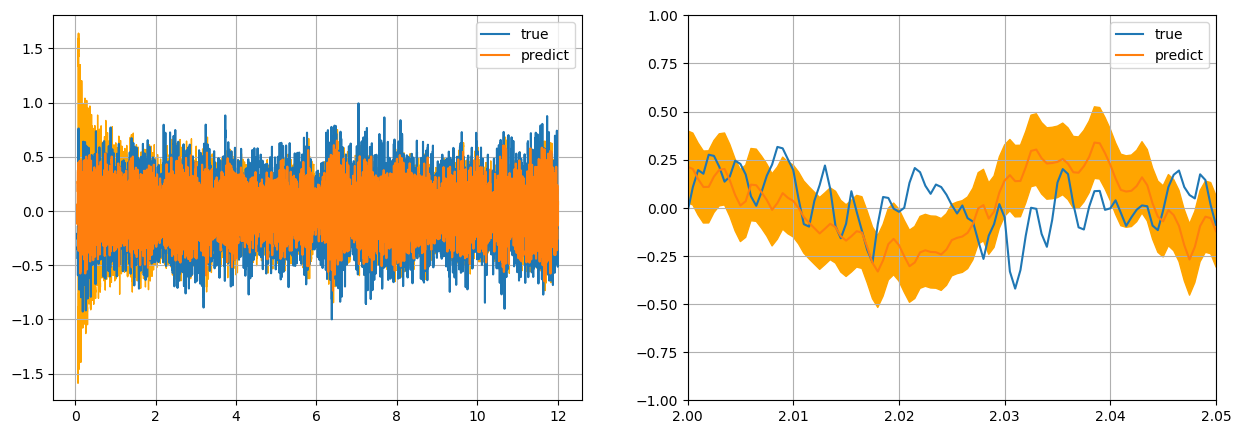

In [16]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(t[bufsize:end], yi[bufsize:end], label="true")
ax[1].plot(t[bufsize:end], Œº_x_mem[bufsize:end], label="predict")
ax[1].fill_between(t[bufsize:end], Œº_x_mem[bufsize:end] .+ sqrt.(Œ£_x_mem[bufsize:end]), Œº_x_mem[bufsize:end] .- sqrt.(Œ£_x_mem[bufsize:end]), color="orange")
ax[1].grid(), ax[1].legend()
ax[2].plot(t[bufsize:end], yi[bufsize:end], label="true")
ax[2].plot(t[bufsize:end], Œº_x_mem[bufsize:end], label="predict")
ax[2].fill_between(t[bufsize:end], Œº_x_mem[bufsize:end] .+ sqrt.(Œ£_x_mem[bufsize:end]), Œº_x_mem[bufsize:end] .- sqrt.(Œ£_x_mem[bufsize:end]), color="orange")
ax[2].grid(), ax[2].legend(), ax[2].set_xlim(2,2.05), ax[2].set_ylim(-1,1)
audioplayers(yi[bufsize:end], Œº_x_mem[bufsize:end], fs=fs*4)

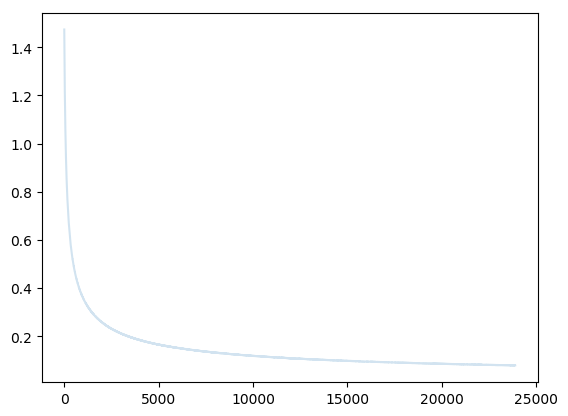

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000064673470>

In [17]:
plt.plot(sqrt.(Œ£_x_mem[bufsize:end]), alpha=0.2)

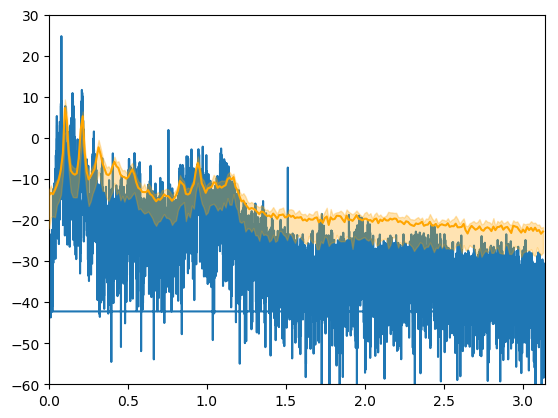

In [18]:
# generation:
Ni = 500 # (nr samples + frequency resolution)
Mi = 100 # nr of iterations

# get parameters
Œº_Œ∏i, Œ£_Œ∏i = ForneyLab.unsafeMean(marginals[:Œ∏]), ForneyLab.unsafeCov(marginals[:Œ∏])
v_wi, nu_wi = marginals[:w].params[:v], marginals[:w].params[:nu]


function generate1psd(Œº_Œ∏i, Œ£_Œ∏i, v_wi, nu_wi, N, fs, f)
    # create signal (option 1)
    sif = Array{Float64,2}(undef, 2*length(f), N)
    xif = Array{Float64,1}(undef, N)
    sif[:,1] = zeros(2*length(f))
    xif[1] = 0
    for n = 2:N
        Œ∏s = rand(MvNormal(Œº_Œ∏i, collect(Hermitian(Œ£_Œ∏i))))
        ws = rand(MvNormal(zeros(2*length(f)), collect(Hermitian(inv(rand(Distributions.Wishart(nu_wi, collect(Hermitian(v_wi)))))))))
        sif[:,n] = Œ∏s.*sif[:,n-1] + ws
        xif[n] = collect(sif[:,n]'*reshape( [cos.(2*pi*f/fs*n') sin.(2*pi*f/fs*n')]', 1, 2*length(f))')[1,1]
    end
    return xif
end

function approxpsd(M, Œº_Œ∏i, Œ£_Œ∏i, v_wi, nu_wi, N, fs, f)
    psd = Array{Float64,2}(undef, M, N) 
    for m = 1:M
        xif = generate1psd(Œº_Œ∏i, Œ£_Œ∏i, v_wi, nu_wi, N, fs, f)
        psd[m,:] = (abs.(FFTW.fft(xif)).^2)./length(xif)
    end
    return squeeze(10*log10.(mean(psd, dims=1))), squeeze(10*log10.([quantile(psd[:,k], 0.25) for k = 1:N])), squeeze(10*log10.([quantile(psd[:,k], 0.75) for k = 1:N]))
end

mean_psd, std_psd1, std_psd2 = approxpsd(Mi, Œº_Œ∏i, Œ£_Œ∏i, v_wi, nu_wi, Ni, fs, f)
mean_psd = mean_psd[1:Int(floor(Ni/2))]
std_psd1 = std_psd1[1:Int(floor(Ni/2))]
std_psd2 = std_psd2[1:Int(floor(Ni/2))]
plt.plot(FFTW.fftfreq(length(yi), fs)/fs*2*pi, 10*log10.((abs.(FFTW.fft(yi)).^2)./length(yi)))
plt.plot(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))]/fs*2*pi, mean_psd, color="orange")
plt.fill_between(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))]/fs*2*pi, std_psd1, std_psd2, color="orange", alpha=0.3, zorder=100)
plt.xlim(0,pi)
plt.ylim(-60,30)
;

In [19]:
x_true = yi[bufsize:end]
x_Œº_pred = Œº_x_mem[bufsize:end]
x_œÉ_pred = sqrt.(abs.(Œ£_x_mem[bufsize:end]));

In [20]:
MSE = mean(abs2.(x_true - x_Œº_pred))
MAE = mean(abs.(x_true - x_Œº_pred))
BME = mean([logpdf(Normal(x_Œº_pred[k], x_œÉ_pred[k]), x_true[k]) for k = 1:length(x_true)])

MSE, MAE, BME

(0.10950401355975699, 0.2701259669938079, -3.0605801793236673)

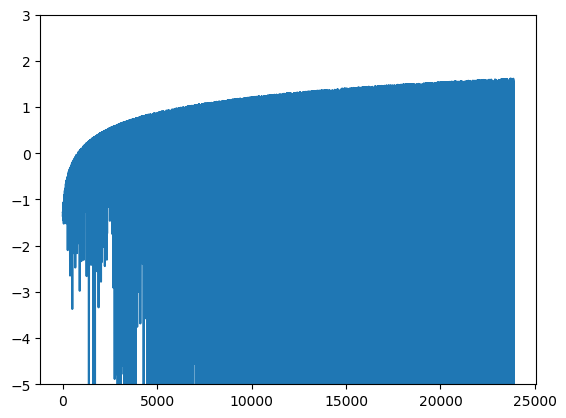

(-5, 3)

In [21]:
plt.plot([logpdf(Normal(x_Œº_pred[k], x_œÉ_pred[k]), x_true[k]) for k = 1:length(x_true)])
plt.ylim(-5,3)